In [26]:
# Import torch

import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(torch.__version__)
## Check if CUDA is available:
print("CUDA available:", torch.cuda.is_available())

## set pytorch tensor / device to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
### tensor = tensor.to(device) to move tensor to GPU

2.5.1
CUDA available: True
Using device: cuda


Credits: https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

In [62]:
X = pd.read_csv("X.csv", index_col = 'Unnamed: 0', parse_dates=True)
y = pd.read_csv("y.csv").AAPL_pred.values
print(f"Imported X and y Shapes: {X.shape}, {y.shape}, \n")

## Standardisation for our training features
## For label y, we will scale and translate each feature individually to between 0 and 1
mm = MinMaxScaler()
ss = StandardScaler()
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1)) # (688,) to reshape to (688, 1)
print(f"X_trans and y_trans Shapes: {X_trans.shape}, {y_trans.shape}, \n")

# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in = 50
n_steps_out = 10
sum_n_steps = n_steps_in + n_steps_out
X_ss, y_mm = split_sequences(X_trans, y_trans, n_steps_in, n_steps_out) # feed in 50 samples, up to the current day, and predict the next 10 time step values
print(f"X_ss and y_mm: {X_ss.shape}, {y_mm.shape}, \n")

total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-sum_n_steps]
X_test = X_ss[-sum_n_steps:]

y_train = y_mm[:-sum_n_steps]
y_test = y_mm[-sum_n_steps:] 

print(f"Training Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Shape: {X_test.shape}, {y_test.shape}, \n") 

### Convert data to tensors
# convert to pytorch tensors, optional to move to cuda
X_train_tensors = (torch.Tensor(X_train)).to(device)
X_test_tensors = (torch.Tensor(X_test)).to(device)

y_train_tensors = (torch.Tensor(y_train)).to(device)
y_test_tensors = (torch.Tensor(y_test)).to(device)

# reshaping tensors to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], n_steps_in, 
                                       X_train_tensors.shape[2])).to(device)
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], n_steps_in, 
                                      X_test_tensors.shape[2])).to(device)

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)



Imported X and y Shapes: (688, 32), (688,), 

X_trans and y_trans Shapes: (688, 32), (688, 1), 

X_ss and y_mm: (630, 50, 32), (630, 10), 

Training Shape: (570, 50, 32), (570, 10)
Testing Shape: (60, 50, 32), (60, 10), 

Training Shape: torch.Size([570, 50, 32]) torch.Size([570, 10])
Testing Shape: torch.Size([60, 50, 32]) torch.Size([60, 10])


In [61]:
y_train_tensors.device

device(type='cpu')

In [35]:
y_train_tensors.shape[1]

10

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.dropout = dropout
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected ; 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.size(0)  # Dynamically get the batch size
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # Output shape: (batch_size, seq_length, hidden_size)

        # Use the last timestep's output
        last_timestep_output = output[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Fully connected layers
        out = self.relu(self.fc_1(last_timestep_output))  # Shape: (batch_size, 128)
        out = self.fc_2(out)  # Shape: (batch_size, num_classes)
        return out
    
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
# n_epochs = 1000 # 1000 epochs
# learning_rate = 0.001 # 0.001 lr
# input_size = X_train_tensors.shape[2] # number of features
# hidden_size = 16 # number of features in hidden state
# num_layers = 1 # number of stacked lstm layers
# dropout = 0.2

# num_classes = y_train_tensors.shape[1] # number of output classes 

# lstm = LSTM(num_classes, 
#               input_size, 
#               hidden_size, 
#               num_layers,
#               dropout).to(device)

# loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
# optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# training_loop(n_epochs=n_epochs,
#               lstm=lstm,
#               optimiser=optimiser,
#               loss_fn=loss_fn,
#               X_train=X_train_tensors_final,
#               y_train=y_train_tensors,
#               X_test=X_test_tensors_final,
#               y_test=y_test_tensors)

c:\Users\limfy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch: 0, train loss: 0.53282, test loss: 0.76238
Epoch: 100, train loss: 0.00422, test loss: 0.06545
Epoch: 200, train loss: 0.00160, test loss: 0.05230
Epoch: 300, train loss: 0.00106, test loss: 0.04855
Epoch: 400, train loss: 0.00081, test loss: 0.04498
Epoch: 500, train loss: 0.00067, test loss: 0.04179
Epoch: 600, train loss: 0.00058, test loss: 0.03904
Epoch: 700, train loss: 0.00051, test loss: 0.03678
Epoch: 800, train loss: 0.00047, test loss: 0.03488
Epoch: 900, train loss: 0.00043, test loss: 0.03325


In [ ]:
import optuna
## Optuna uses Bayesian Optimization to hyperparameter tune

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float("dropout", low = 0.0, high = 0.4, step = 0.05, log = False)

    # Create the model
    model = LSTM(num_classes, input_size, hidden_size, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    # Train the model
    training_loop(n_epochs=1000, lstm=model, optimiser=optimizer, loss_fn=loss_fn,
                  X_train=X_train_tensors_final, y_train=y_train_tensors,
                  X_test=X_test_tensors_final, y_test=y_test_tensors)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensors_final)
        val_loss = loss_fn(val_preds, y_test_tensors).item()

    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2024-12-09 12:02:59,040] A new study created in memory with name: no-name-0cfdda72-a842-49e9-bcfb-6e786aca271c
C:\Users\limfy\AppData\Local\Temp\ipykernel_24892\3914893301.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)


Epoch: 0, train loss: 0.53609, test loss: 0.76962
Epoch: 100, train loss: 0.00123, test loss: 0.00539
Epoch: 200, train loss: 0.00086, test loss: 0.00417
Epoch: 300, train loss: 0.00070, test loss: 0.00369
Epoch: 400, train loss: 0.00061, test loss: 0.00379
Epoch: 500, train loss: 0.00057, test loss: 0.00365
Epoch: 600, train loss: 0.00053, test loss: 0.00385
Epoch: 700, train loss: 0.00048, test loss: 0.00416
Epoch: 800, train loss: 0.00041, test loss: 0.00382
Epoch: 900, train loss: 0.00035, test loss: 0.00360


[I 2024-12-09 12:03:07,853] Trial 0 finished with value: 0.0034854873083531857 and parameters: {'lr': 0.0014258185574881142, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.52647, test loss: 0.71311
Epoch: 100, train loss: 0.00087, test loss: 0.00325
Epoch: 200, train loss: 0.00064, test loss: 0.00578
Epoch: 300, train loss: 0.00048, test loss: 0.00850
Epoch: 400, train loss: 0.00036, test loss: 0.00876
Epoch: 500, train loss: 0.00033, test loss: 0.00886
Epoch: 600, train loss: 0.00029, test loss: 0.00960
Epoch: 700, train loss: 0.00026, test loss: 0.00921
Epoch: 800, train loss: 0.00025, test loss: 0.00909
Epoch: 900, train loss: 0.00023, test loss: 0.00899


[I 2024-12-09 12:03:13,959] Trial 1 finished with value: 0.009249025024473667 and parameters: {'lr': 0.00430967483456495, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4}. Best is trial 0 with value: 0.0034854873083531857.
c:\Users\limfy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch: 0, train loss: 0.47047, test loss: 0.67194
Epoch: 100, train loss: 0.00115, test loss: 0.02634
Epoch: 200, train loss: 0.00064, test loss: 0.02697
Epoch: 300, train loss: 0.00046, test loss: 0.02855
Epoch: 400, train loss: 0.00036, test loss: 0.02929
Epoch: 500, train loss: 0.00030, test loss: 0.02958
Epoch: 600, train loss: 0.00025, test loss: 0.03016
Epoch: 700, train loss: 0.00022, test loss: 0.03064
Epoch: 800, train loss: 0.00020, test loss: 0.03127
Epoch: 900, train loss: 0.00018, test loss: 0.03192


[I 2024-12-09 12:03:18,245] Trial 2 finished with value: 0.03242424502968788 and parameters: {'lr': 0.0015972796183156709, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.1}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.52676, test loss: 0.77356
Epoch: 100, train loss: 0.00277, test loss: 0.00518
Epoch: 200, train loss: 0.00173, test loss: 0.00346
Epoch: 300, train loss: 0.00133, test loss: 0.00366
Epoch: 400, train loss: 0.00113, test loss: 0.00398
Epoch: 500, train loss: 0.00101, test loss: 0.00416
Epoch: 600, train loss: 0.00093, test loss: 0.00446
Epoch: 700, train loss: 0.00079, test loss: 0.00442
Epoch: 800, train loss: 0.00077, test loss: 0.00468
Epoch: 900, train loss: 0.00071, test loss: 0.00472


[I 2024-12-09 12:03:23,117] Trial 3 finished with value: 0.004342770669609308 and parameters: {'lr': 0.0005218023429488851, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.4}. Best is trial 0 with value: 0.0034854873083531857.
c:\Users\limfy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch: 0, train loss: 0.50407, test loss: 0.75647
Epoch: 100, train loss: 0.28133, test loss: 0.46545
Epoch: 200, train loss: 0.02646, test loss: 0.16065
Epoch: 300, train loss: 0.00780, test loss: 0.14304
Epoch: 400, train loss: 0.00440, test loss: 0.12132
Epoch: 500, train loss: 0.00305, test loss: 0.10785
Epoch: 600, train loss: 0.00241, test loss: 0.09896
Epoch: 700, train loss: 0.00203, test loss: 0.09313
Epoch: 800, train loss: 0.00176, test loss: 0.08915
Epoch: 900, train loss: 0.00154, test loss: 0.08651


[I 2024-12-09 12:03:26,723] Trial 4 finished with value: 0.08443475514650345 and parameters: {'lr': 0.00010626374339761234, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.48616, test loss: 0.71975
Epoch: 100, train loss: 0.00297, test loss: 0.00188
Epoch: 200, train loss: 0.00137, test loss: 0.00137
Epoch: 300, train loss: 0.00107, test loss: 0.00202
Epoch: 400, train loss: 0.00088, test loss: 0.00261
Epoch: 500, train loss: 0.00082, test loss: 0.00295
Epoch: 600, train loss: 0.00076, test loss: 0.00319
Epoch: 700, train loss: 0.00070, test loss: 0.00346
Epoch: 800, train loss: 0.00066, test loss: 0.00398
Epoch: 900, train loss: 0.00066, test loss: 0.00399


[I 2024-12-09 12:03:32,432] Trial 5 finished with value: 0.004197308328002691 and parameters: {'lr': 0.0005745938945967565, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.48618, test loss: 0.67156
Epoch: 100, train loss: 0.00071, test loss: 0.00272
Epoch: 200, train loss: 0.00051, test loss: 0.00509
Epoch: 300, train loss: 0.00041, test loss: 0.00716
Epoch: 400, train loss: 0.00030, test loss: 0.00851
Epoch: 500, train loss: 0.00025, test loss: 0.00890
Epoch: 600, train loss: 0.00023, test loss: 0.00810
Epoch: 700, train loss: 0.00020, test loss: 0.00738
Epoch: 800, train loss: 0.00019, test loss: 0.00695
Epoch: 900, train loss: 0.00017, test loss: 0.00657


[I 2024-12-09 12:03:38,419] Trial 6 finished with value: 0.006294415332376957 and parameters: {'lr': 0.003918666341855426, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.54268, test loss: 0.73726
Epoch: 100, train loss: 0.00084, test loss: 0.02015
Epoch: 200, train loss: 0.00054, test loss: 0.02101
Epoch: 300, train loss: 0.00039, test loss: 0.02269
Epoch: 400, train loss: 0.00031, test loss: 0.02415
Epoch: 500, train loss: 0.00025, test loss: 0.02500
Epoch: 600, train loss: 0.00021, test loss: 0.02589
Epoch: 700, train loss: 0.00018, test loss: 0.02696
Epoch: 800, train loss: 0.00016, test loss: 0.02800
Epoch: 900, train loss: 0.00014, test loss: 0.02886


[I 2024-12-09 12:03:42,153] Trial 7 finished with value: 0.02919013798236847 and parameters: {'lr': 0.003065109623518796, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.53828, test loss: 0.78871
Epoch: 100, train loss: 0.00238, test loss: 0.00570
Epoch: 200, train loss: 0.00147, test loss: 0.00753
Epoch: 300, train loss: 0.00117, test loss: 0.00751
Epoch: 400, train loss: 0.00093, test loss: 0.00651
Epoch: 500, train loss: 0.00079, test loss: 0.00570
Epoch: 600, train loss: 0.00074, test loss: 0.00512
Epoch: 700, train loss: 0.00064, test loss: 0.00524
Epoch: 800, train loss: 0.00059, test loss: 0.00483
Epoch: 900, train loss: 0.00055, test loss: 0.00535


[I 2024-12-09 12:03:46,813] Trial 8 finished with value: 0.005657079163938761 and parameters: {'lr': 0.0007245353958703425, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.35000000000000003}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.53115, test loss: 0.77251
Epoch: 100, train loss: 0.00188, test loss: 0.00399
Epoch: 200, train loss: 0.00085, test loss: 0.00588
Epoch: 300, train loss: 0.00069, test loss: 0.00715
Epoch: 400, train loss: 0.00060, test loss: 0.00749
Epoch: 500, train loss: 0.00055, test loss: 0.00745
Epoch: 600, train loss: 0.00050, test loss: 0.00746
Epoch: 700, train loss: 0.00046, test loss: 0.00743
Epoch: 800, train loss: 0.00043, test loss: 0.00718
Epoch: 900, train loss: 0.00039, test loss: 0.00730


[I 2024-12-09 12:03:52,779] Trial 9 finished with value: 0.0069528669118881226 and parameters: {'lr': 0.0010172323491742907, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.05}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.54868, test loss: 0.63979
Epoch: 100, train loss: 0.00112, test loss: 0.00211
Epoch: 200, train loss: 0.00084, test loss: 0.00296
Epoch: 300, train loss: 0.00064, test loss: 0.00536
Epoch: 400, train loss: 0.00056, test loss: 0.00829
Epoch: 500, train loss: 0.00048, test loss: 0.01112
Epoch: 600, train loss: 0.00042, test loss: 0.01384
Epoch: 700, train loss: 0.00040, test loss: 0.01530
Epoch: 800, train loss: 0.00037, test loss: 0.01665
Epoch: 900, train loss: 0.00033, test loss: 0.01732


[I 2024-12-09 12:03:58,591] Trial 10 finished with value: 0.017727578058838844 and parameters: {'lr': 0.009318567218552433, 'hidden_size': 16, 'num_layers': 3, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.56430, test loss: 0.82898
Epoch: 100, train loss: 0.03531, test loss: 0.07641
Epoch: 200, train loss: 0.00551, test loss: 0.01948
Epoch: 300, train loss: 0.00314, test loss: 0.01097
Epoch: 400, train loss: 0.00222, test loss: 0.01214
Epoch: 500, train loss: 0.00183, test loss: 0.01534
Epoch: 600, train loss: 0.00162, test loss: 0.01776
Epoch: 700, train loss: 0.00150, test loss: 0.01922
Epoch: 800, train loss: 0.00137, test loss: 0.01982
Epoch: 900, train loss: 0.00121, test loss: 0.01999


[I 2024-12-09 12:04:04,166] Trial 11 finished with value: 0.0198680367320776 and parameters: {'lr': 0.0002284579293493567, 'hidden_size': 16, 'num_layers': 3, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.51910, test loss: 0.77169
Epoch: 100, train loss: 0.00357, test loss: 0.00641
Epoch: 200, train loss: 0.00135, test loss: 0.00688
Epoch: 300, train loss: 0.00107, test loss: 0.00789
Epoch: 400, train loss: 0.00090, test loss: 0.00886
Epoch: 500, train loss: 0.00076, test loss: 0.00971
Epoch: 600, train loss: 0.00069, test loss: 0.00951
Epoch: 700, train loss: 0.00066, test loss: 0.00920
Epoch: 800, train loss: 0.00060, test loss: 0.00857
Epoch: 900, train loss: 0.00056, test loss: 0.00828


[I 2024-12-09 12:04:12,765] Trial 12 finished with value: 0.007899735122919083 and parameters: {'lr': 0.0003539302903349538, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.54522, test loss: 0.77938
Epoch: 100, train loss: 0.00173, test loss: 0.00187
Epoch: 200, train loss: 0.00088, test loss: 0.00415
Epoch: 300, train loss: 0.00076, test loss: 0.00515
Epoch: 400, train loss: 0.00067, test loss: 0.00614
Epoch: 500, train loss: 0.00060, test loss: 0.00673
Epoch: 600, train loss: 0.00054, test loss: 0.00777
Epoch: 700, train loss: 0.00048, test loss: 0.00870
Epoch: 800, train loss: 0.00043, test loss: 0.00927
Epoch: 900, train loss: 0.00038, test loss: 0.00963


[I 2024-12-09 12:04:19,072] Trial 13 finished with value: 0.009920150972902775 and parameters: {'lr': 0.0014935938519576872, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.57238, test loss: 0.83682
Epoch: 100, train loss: 0.03939, test loss: 0.06767
Epoch: 200, train loss: 0.00527, test loss: 0.00521
Epoch: 300, train loss: 0.00273, test loss: 0.00432
Epoch: 400, train loss: 0.00219, test loss: 0.00526
Epoch: 500, train loss: 0.00173, test loss: 0.00592
Epoch: 600, train loss: 0.00154, test loss: 0.00658
Epoch: 700, train loss: 0.00140, test loss: 0.00712
Epoch: 800, train loss: 0.00133, test loss: 0.00784
Epoch: 900, train loss: 0.00117, test loss: 0.00811


[I 2024-12-09 12:04:24,107] Trial 14 finished with value: 0.00883090402930975 and parameters: {'lr': 0.00023094708706342075, 'hidden_size': 16, 'num_layers': 3, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.57793, test loss: 0.80990
Epoch: 100, train loss: 0.00112, test loss: 0.00166
Epoch: 200, train loss: 0.00067, test loss: 0.00381
Epoch: 300, train loss: 0.00053, test loss: 0.00509
Epoch: 400, train loss: 0.00047, test loss: 0.00582
Epoch: 500, train loss: 0.00038, test loss: 0.00629
Epoch: 600, train loss: 0.00032, test loss: 0.00624
Epoch: 700, train loss: 0.00029, test loss: 0.00619
Epoch: 800, train loss: 0.00028, test loss: 0.00605
Epoch: 900, train loss: 0.00027, test loss: 0.00563


[I 2024-12-09 12:04:32,477] Trial 15 finished with value: 0.0053917174227535725 and parameters: {'lr': 0.0019240088087773698, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.1}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.56113, test loss: 0.81695
Epoch: 100, train loss: 0.00243, test loss: 0.00624
Epoch: 200, train loss: 0.00141, test loss: 0.00613
Epoch: 300, train loss: 0.00111, test loss: 0.00705
Epoch: 400, train loss: 0.00093, test loss: 0.00781
Epoch: 500, train loss: 0.00085, test loss: 0.00883
Epoch: 600, train loss: 0.00074, test loss: 0.00912
Epoch: 700, train loss: 0.00067, test loss: 0.00957
Epoch: 800, train loss: 0.00060, test loss: 0.01024
Epoch: 900, train loss: 0.00054, test loss: 0.01003


[I 2024-12-09 12:04:37,198] Trial 16 finished with value: 0.010865774005651474 and parameters: {'lr': 0.0007266130129005809, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.50780, test loss: 0.75449
Epoch: 100, train loss: 0.00476, test loss: 0.00591
Epoch: 200, train loss: 0.00163, test loss: 0.00640
Epoch: 300, train loss: 0.00114, test loss: 0.00656
Epoch: 400, train loss: 0.00103, test loss: 0.00700
Epoch: 500, train loss: 0.00090, test loss: 0.00695
Epoch: 600, train loss: 0.00080, test loss: 0.00683
Epoch: 700, train loss: 0.00078, test loss: 0.00661
Epoch: 800, train loss: 0.00076, test loss: 0.00665
Epoch: 900, train loss: 0.00066, test loss: 0.00672


[I 2024-12-09 12:04:42,950] Trial 17 finished with value: 0.0067076790146529675 and parameters: {'lr': 0.00032935260842004946, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.51876, test loss: 0.77100
Epoch: 100, train loss: 0.03443, test loss: 0.09790
Epoch: 200, train loss: 0.00231, test loss: 0.02558
Epoch: 300, train loss: 0.00179, test loss: 0.01867
Epoch: 400, train loss: 0.00155, test loss: 0.01655
Epoch: 500, train loss: 0.00139, test loss: 0.01568
Epoch: 600, train loss: 0.00120, test loss: 0.01518
Epoch: 700, train loss: 0.00115, test loss: 0.01474
Epoch: 800, train loss: 0.00105, test loss: 0.01458
Epoch: 900, train loss: 0.00103, test loss: 0.01437


[I 2024-12-09 12:04:49,056] Trial 18 finished with value: 0.014438615180552006 and parameters: {'lr': 0.00010909248977416695, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.55952, test loss: 0.69553
Epoch: 100, train loss: 0.00091, test loss: 0.00251
Epoch: 200, train loss: 0.00068, test loss: 0.00371
Epoch: 300, train loss: 0.00060, test loss: 0.00425
Epoch: 400, train loss: 0.00054, test loss: 0.00486
Epoch: 500, train loss: 0.00046, test loss: 0.00570
Epoch: 600, train loss: 0.00039, test loss: 0.00725
Epoch: 700, train loss: 0.00035, test loss: 0.00912
Epoch: 800, train loss: 0.00033, test loss: 0.01132
Epoch: 900, train loss: 0.00030, test loss: 0.01289


[I 2024-12-09 12:04:54,069] Trial 19 finished with value: 0.01362618524581194 and parameters: {'lr': 0.007257428101662321, 'hidden_size': 16, 'num_layers': 3, 'dropout': 0.1}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.52023, test loss: 0.73363
Epoch: 100, train loss: 0.00113, test loss: 0.00131
Epoch: 200, train loss: 0.00074, test loss: 0.00318
Epoch: 300, train loss: 0.00057, test loss: 0.00512
Epoch: 400, train loss: 0.00044, test loss: 0.00654
Epoch: 500, train loss: 0.00036, test loss: 0.00675
Epoch: 600, train loss: 0.00033, test loss: 0.00715
Epoch: 700, train loss: 0.00030, test loss: 0.00768
Epoch: 800, train loss: 0.00028, test loss: 0.00751
Epoch: 900, train loss: 0.00026, test loss: 0.00725


[I 2024-12-09 12:05:00,394] Trial 20 finished with value: 0.007062672171741724 and parameters: {'lr': 0.002232929928654689, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.45298, test loss: 0.67617
Epoch: 100, train loss: 0.00296, test loss: 0.01781
Epoch: 200, train loss: 0.00191, test loss: 0.01222
Epoch: 300, train loss: 0.00153, test loss: 0.01077
Epoch: 400, train loss: 0.00114, test loss: 0.00976
Epoch: 500, train loss: 0.00105, test loss: 0.00875
Epoch: 600, train loss: 0.00098, test loss: 0.00839
Epoch: 700, train loss: 0.00083, test loss: 0.00899
Epoch: 800, train loss: 0.00075, test loss: 0.00798
Epoch: 900, train loss: 0.00074, test loss: 0.00812


[I 2024-12-09 12:05:05,726] Trial 21 finished with value: 0.008201153948903084 and parameters: {'lr': 0.0005420223647633379, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.4}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.53547, test loss: 0.78247
Epoch: 100, train loss: 0.00177, test loss: 0.00914
Epoch: 200, train loss: 0.00110, test loss: 0.00904
Epoch: 300, train loss: 0.00086, test loss: 0.00951
Epoch: 400, train loss: 0.00080, test loss: 0.00971
Epoch: 500, train loss: 0.00069, test loss: 0.01005
Epoch: 600, train loss: 0.00064, test loss: 0.00987
Epoch: 700, train loss: 0.00054, test loss: 0.01028
Epoch: 800, train loss: 0.00051, test loss: 0.01055
Epoch: 900, train loss: 0.00046, test loss: 0.01048


[I 2024-12-09 12:05:10,481] Trial 22 finished with value: 0.010106491856276989 and parameters: {'lr': 0.0009244092782241615, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.47576, test loss: 0.71307
Epoch: 100, train loss: 0.00389, test loss: 0.01852
Epoch: 200, train loss: 0.00170, test loss: 0.00931
Epoch: 300, train loss: 0.00139, test loss: 0.01026
Epoch: 400, train loss: 0.00119, test loss: 0.00984
Epoch: 500, train loss: 0.00106, test loss: 0.00929
Epoch: 600, train loss: 0.00091, test loss: 0.00882
Epoch: 700, train loss: 0.00085, test loss: 0.00846
Epoch: 800, train loss: 0.00075, test loss: 0.00861
Epoch: 900, train loss: 0.00071, test loss: 0.00875


[I 2024-12-09 12:05:15,654] Trial 23 finished with value: 0.0086001455783844 and parameters: {'lr': 0.00039704306179407515, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.35000000000000003}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.53776, test loss: 0.78007
Epoch: 100, train loss: 0.00191, test loss: 0.00316
Epoch: 200, train loss: 0.00106, test loss: 0.00506
Epoch: 300, train loss: 0.00085, test loss: 0.00736
Epoch: 400, train loss: 0.00076, test loss: 0.00806
Epoch: 500, train loss: 0.00069, test loss: 0.00856
Epoch: 600, train loss: 0.00067, test loss: 0.00901
Epoch: 700, train loss: 0.00061, test loss: 0.00961
Epoch: 800, train loss: 0.00056, test loss: 0.01064
Epoch: 900, train loss: 0.00047, test loss: 0.01163


[I 2024-12-09 12:05:21,545] Trial 24 finished with value: 0.01251912396401167 and parameters: {'lr': 0.0011954903863857632, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.
c:\Users\limfy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15000000000000002 and num_layers=1
  warnings.warn(


Epoch: 0, train loss: 0.56533, test loss: 0.82023
Epoch: 100, train loss: 0.00488, test loss: 0.09870
Epoch: 200, train loss: 0.00171, test loss: 0.07972
Epoch: 300, train loss: 0.00119, test loss: 0.07456
Epoch: 400, train loss: 0.00096, test loss: 0.07058
Epoch: 500, train loss: 0.00081, test loss: 0.06816
Epoch: 600, train loss: 0.00071, test loss: 0.06638
Epoch: 700, train loss: 0.00063, test loss: 0.06520
Epoch: 800, train loss: 0.00057, test loss: 0.06425
Epoch: 900, train loss: 0.00051, test loss: 0.06362


[I 2024-12-09 12:05:24,968] Trial 25 finished with value: 0.06319458037614822 and parameters: {'lr': 0.00044974746019056314, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.57450, test loss: 0.83282
Epoch: 100, train loss: 0.00279, test loss: 0.00474
Epoch: 200, train loss: 0.00144, test loss: 0.00586
Epoch: 300, train loss: 0.00122, test loss: 0.00514
Epoch: 400, train loss: 0.00098, test loss: 0.00533
Epoch: 500, train loss: 0.00090, test loss: 0.00575
Epoch: 600, train loss: 0.00079, test loss: 0.00651
Epoch: 700, train loss: 0.00072, test loss: 0.00695
Epoch: 800, train loss: 0.00069, test loss: 0.00804
Epoch: 900, train loss: 0.00063, test loss: 0.00907


[I 2024-12-09 12:05:30,680] Trial 26 finished with value: 0.009898260235786438 and parameters: {'lr': 0.0006712501562258337, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.35000000000000003}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.47707, test loss: 0.72390
Epoch: 100, train loss: 0.01161, test loss: 0.06734
Epoch: 200, train loss: 0.00264, test loss: 0.01412
Epoch: 300, train loss: 0.00171, test loss: 0.00763
Epoch: 400, train loss: 0.00137, test loss: 0.00520
Epoch: 500, train loss: 0.00117, test loss: 0.00407
Epoch: 600, train loss: 0.00103, test loss: 0.00406
Epoch: 700, train loss: 0.00099, test loss: 0.00419
Epoch: 800, train loss: 0.00089, test loss: 0.00427
Epoch: 900, train loss: 0.00080, test loss: 0.00488


[I 2024-12-09 12:05:35,764] Trial 27 finished with value: 0.005007891915738583 and parameters: {'lr': 0.00023021908458871555, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.57182, test loss: 0.81460
Epoch: 100, train loss: 0.00243, test loss: 0.00159
Epoch: 200, train loss: 0.00098, test loss: 0.00670
Epoch: 300, train loss: 0.00075, test loss: 0.00977
Epoch: 400, train loss: 0.00071, test loss: 0.00936
Epoch: 500, train loss: 0.00065, test loss: 0.00853
Epoch: 600, train loss: 0.00061, test loss: 0.00772
Epoch: 700, train loss: 0.00057, test loss: 0.00715
Epoch: 800, train loss: 0.00054, test loss: 0.00692
Epoch: 900, train loss: 0.00051, test loss: 0.00730


[I 2024-12-09 12:05:40,879] Trial 28 finished with value: 0.00781608372926712 and parameters: {'lr': 0.0011658044703944626, 'hidden_size': 16, 'num_layers': 3, 'dropout': 0.05}. Best is trial 0 with value: 0.0034854873083531857.
c:\Users\limfy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch: 0, train loss: 0.50585, test loss: 0.72643
Epoch: 100, train loss: 0.03537, test loss: 0.18867
Epoch: 200, train loss: 0.00330, test loss: 0.14418
Epoch: 300, train loss: 0.00168, test loss: 0.10780
Epoch: 400, train loss: 0.00127, test loss: 0.09347
Epoch: 500, train loss: 0.00106, test loss: 0.08695
Epoch: 600, train loss: 0.00091, test loss: 0.08401
Epoch: 700, train loss: 0.00081, test loss: 0.08323
Epoch: 800, train loss: 0.00072, test loss: 0.08312
Epoch: 900, train loss: 0.00066, test loss: 0.08348


[I 2024-12-09 12:05:44,943] Trial 29 finished with value: 0.0845026820898056 and parameters: {'lr': 0.0001614127745614682, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.4}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.51309, test loss: 0.72297
Epoch: 100, train loss: 0.00102, test loss: 0.00172
Epoch: 200, train loss: 0.00067, test loss: 0.00300
Epoch: 300, train loss: 0.00055, test loss: 0.00431
Epoch: 400, train loss: 0.00045, test loss: 0.00430
Epoch: 500, train loss: 0.00038, test loss: 0.00470
Epoch: 600, train loss: 0.00034, test loss: 0.00472
Epoch: 700, train loss: 0.00030, test loss: 0.00479
Epoch: 800, train loss: 0.00028, test loss: 0.00477
Epoch: 900, train loss: 0.00025, test loss: 0.00446


[I 2024-12-09 12:05:50,993] Trial 30 finished with value: 0.004322407301515341 and parameters: {'lr': 0.0023794893925676353, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.50360, test loss: 0.69011
Epoch: 100, train loss: 0.00103, test loss: 0.00167
Epoch: 200, train loss: 0.00070, test loss: 0.00392
Epoch: 300, train loss: 0.00051, test loss: 0.00496
Epoch: 400, train loss: 0.00043, test loss: 0.00480
Epoch: 500, train loss: 0.00037, test loss: 0.00543
Epoch: 600, train loss: 0.00033, test loss: 0.00586
Epoch: 700, train loss: 0.00030, test loss: 0.00626
Epoch: 800, train loss: 0.00028, test loss: 0.00644
Epoch: 900, train loss: 0.00026, test loss: 0.00676


[I 2024-12-09 12:05:57,280] Trial 31 finished with value: 0.007216565776616335 and parameters: {'lr': 0.0026467731658743193, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.50916, test loss: 0.65738
Epoch: 100, train loss: 0.00082, test loss: 0.00425
Epoch: 200, train loss: 0.00058, test loss: 0.00807
Epoch: 300, train loss: 0.00044, test loss: 0.00950
Epoch: 400, train loss: 0.00033, test loss: 0.01008
Epoch: 500, train loss: 0.00027, test loss: 0.01042
Epoch: 600, train loss: 0.00023, test loss: 0.01073
Epoch: 700, train loss: 0.00021, test loss: 0.01002
Epoch: 800, train loss: 0.00019, test loss: 0.00979
Epoch: 900, train loss: 0.00017, test loss: 0.01041


[I 2024-12-09 12:06:03,373] Trial 32 finished with value: 0.010005285032093525 and parameters: {'lr': 0.004950237820715859, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.56725, test loss: 0.80931
Epoch: 100, train loss: 0.00145, test loss: 0.00325
Epoch: 200, train loss: 0.00092, test loss: 0.00580
Epoch: 300, train loss: 0.00075, test loss: 0.00679
Epoch: 400, train loss: 0.00064, test loss: 0.00722
Epoch: 500, train loss: 0.00055, test loss: 0.00833
Epoch: 600, train loss: 0.00049, test loss: 0.00783
Epoch: 700, train loss: 0.00042, test loss: 0.00773
Epoch: 800, train loss: 0.00035, test loss: 0.00837
Epoch: 900, train loss: 0.00032, test loss: 0.00940


[I 2024-12-09 12:06:09,694] Trial 33 finished with value: 0.010291515849530697 and parameters: {'lr': 0.0015831565616438272, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.35000000000000003}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.50420, test loss: 0.65463
Epoch: 100, train loss: 0.00080, test loss: 0.03935
Epoch: 200, train loss: 0.00050, test loss: 0.04690
Epoch: 300, train loss: 0.00036, test loss: 0.05311
Epoch: 400, train loss: 0.00027, test loss: 0.05502
Epoch: 500, train loss: 0.00022, test loss: 0.05418
Epoch: 600, train loss: 0.00019, test loss: 0.05390
Epoch: 700, train loss: 0.00016, test loss: 0.05474
Epoch: 800, train loss: 0.00014, test loss: 0.05522
Epoch: 900, train loss: 0.00012, test loss: 0.05591


[I 2024-12-09 12:06:13,383] Trial 34 finished with value: 0.05677672103047371 and parameters: {'lr': 0.0038469043805648066, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.51484, test loss: 0.76843
Epoch: 100, train loss: 0.00204, test loss: 0.01051
Epoch: 200, train loss: 0.00132, test loss: 0.00927
Epoch: 300, train loss: 0.00097, test loss: 0.00807
Epoch: 400, train loss: 0.00084, test loss: 0.00845
Epoch: 500, train loss: 0.00073, test loss: 0.00867
Epoch: 600, train loss: 0.00066, test loss: 0.00938
Epoch: 700, train loss: 0.00058, test loss: 0.00948
Epoch: 800, train loss: 0.00053, test loss: 0.01001
Epoch: 900, train loss: 0.00046, test loss: 0.01037


[I 2024-12-09 12:06:19,427] Trial 35 finished with value: 0.010649851523339748 and parameters: {'lr': 0.000540105177839626, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.54972, test loss: 0.80449
Epoch: 100, train loss: 0.00159, test loss: 0.00824
Epoch: 200, train loss: 0.00097, test loss: 0.00879
Epoch: 300, train loss: 0.00078, test loss: 0.00886
Epoch: 400, train loss: 0.00071, test loss: 0.00862
Epoch: 500, train loss: 0.00063, test loss: 0.00806
Epoch: 600, train loss: 0.00056, test loss: 0.00812
Epoch: 700, train loss: 0.00049, test loss: 0.00832
Epoch: 800, train loss: 0.00042, test loss: 0.00768
Epoch: 900, train loss: 0.00036, test loss: 0.00785


[I 2024-12-09 12:06:25,433] Trial 36 finished with value: 0.007400539703667164 and parameters: {'lr': 0.0009035800798172067, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.
c:\Users\limfy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


Epoch: 0, train loss: 0.55080, test loss: 0.77840
Epoch: 100, train loss: 0.00146, test loss: 0.03915
Epoch: 200, train loss: 0.00082, test loss: 0.03816
Epoch: 300, train loss: 0.00059, test loss: 0.03739
Epoch: 400, train loss: 0.00045, test loss: 0.03719
Epoch: 500, train loss: 0.00036, test loss: 0.03731
Epoch: 600, train loss: 0.00030, test loss: 0.03778
Epoch: 700, train loss: 0.00026, test loss: 0.03812
Epoch: 800, train loss: 0.00023, test loss: 0.03835
Epoch: 900, train loss: 0.00021, test loss: 0.03849


[I 2024-12-09 12:06:28,449] Trial 37 finished with value: 0.03863508626818657 and parameters: {'lr': 0.0020640283779169415, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.52242, test loss: 0.74939
Epoch: 100, train loss: 0.00147, test loss: 0.00605
Epoch: 200, train loss: 0.00092, test loss: 0.00684
Epoch: 300, train loss: 0.00076, test loss: 0.00745
Epoch: 400, train loss: 0.00067, test loss: 0.00840
Epoch: 500, train loss: 0.00056, test loss: 0.00936
Epoch: 600, train loss: 0.00045, test loss: 0.01163
Epoch: 700, train loss: 0.00038, test loss: 0.01251
Epoch: 800, train loss: 0.00034, test loss: 0.01327
Epoch: 900, train loss: 0.00032, test loss: 0.01322


[I 2024-12-09 12:06:34,377] Trial 38 finished with value: 0.013020157814025879 and parameters: {'lr': 0.0012624892042972543, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.35000000000000003}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.48952, test loss: 0.68648
Epoch: 100, train loss: 0.00115, test loss: 0.00104
Epoch: 200, train loss: 0.00069, test loss: 0.00431
Epoch: 300, train loss: 0.00062, test loss: 0.00473
Epoch: 400, train loss: 0.00057, test loss: 0.00521
Epoch: 500, train loss: 0.00052, test loss: 0.00524
Epoch: 600, train loss: 0.00041, test loss: 0.00587
Epoch: 700, train loss: 0.00037, test loss: 0.00687
Epoch: 800, train loss: 0.00035, test loss: 0.00669
Epoch: 900, train loss: 0.00033, test loss: 0.00535


[I 2024-12-09 12:06:39,775] Trial 39 finished with value: 0.0051467823795974255 and parameters: {'lr': 0.0030646419513512316, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.52014, test loss: 0.77492
Epoch: 100, train loss: 0.00265, test loss: 0.04208
Epoch: 200, train loss: 0.00168, test loss: 0.02932
Epoch: 300, train loss: 0.00125, test loss: 0.02562
Epoch: 400, train loss: 0.00100, test loss: 0.02454
Epoch: 500, train loss: 0.00087, test loss: 0.02440
Epoch: 600, train loss: 0.00075, test loss: 0.02478
Epoch: 700, train loss: 0.00071, test loss: 0.02510
Epoch: 800, train loss: 0.00063, test loss: 0.02523
Epoch: 900, train loss: 0.00059, test loss: 0.02566


[I 2024-12-09 12:06:45,639] Trial 40 finished with value: 0.025913499295711517 and parameters: {'lr': 0.0002946840417505472, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.50042, test loss: 0.74829
Epoch: 100, train loss: 0.05899, test loss: 0.19008
Epoch: 200, train loss: 0.00379, test loss: 0.06303
Epoch: 300, train loss: 0.00249, test loss: 0.05030
Epoch: 400, train loss: 0.00182, test loss: 0.04520
Epoch: 500, train loss: 0.00155, test loss: 0.04471
Epoch: 600, train loss: 0.00139, test loss: 0.04352
Epoch: 700, train loss: 0.00125, test loss: 0.04154
Epoch: 800, train loss: 0.00119, test loss: 0.03978
Epoch: 900, train loss: 0.00115, test loss: 0.03829


[I 2024-12-09 12:06:49,944] Trial 41 finished with value: 0.0375836081802845 and parameters: {'lr': 0.00016212068751258213, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.53548, test loss: 0.78487
Epoch: 100, train loss: 0.00285, test loss: 0.01765
Epoch: 200, train loss: 0.00152, test loss: 0.01331
Epoch: 300, train loss: 0.00117, test loss: 0.01322
Epoch: 400, train loss: 0.00103, test loss: 0.01275
Epoch: 500, train loss: 0.00092, test loss: 0.01178
Epoch: 600, train loss: 0.00082, test loss: 0.01144
Epoch: 700, train loss: 0.00074, test loss: 0.01157
Epoch: 800, train loss: 0.00069, test loss: 0.01090
Epoch: 900, train loss: 0.00063, test loss: 0.01092


[I 2024-12-09 12:06:54,379] Trial 42 finished with value: 0.010845205746591091 and parameters: {'lr': 0.0005142085987547509, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.49440, test loss: 0.73305
Epoch: 100, train loss: 0.00631, test loss: 0.02238
Epoch: 200, train loss: 0.00231, test loss: 0.00890
Epoch: 300, train loss: 0.00157, test loss: 0.00685
Epoch: 400, train loss: 0.00137, test loss: 0.00626
Epoch: 500, train loss: 0.00112, test loss: 0.00583
Epoch: 600, train loss: 0.00101, test loss: 0.00585
Epoch: 700, train loss: 0.00093, test loss: 0.00591
Epoch: 800, train loss: 0.00086, test loss: 0.00573
Epoch: 900, train loss: 0.00080, test loss: 0.00570


[I 2024-12-09 12:06:58,702] Trial 43 finished with value: 0.006025996524840593 and parameters: {'lr': 0.00026326568379166565, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.53532, test loss: 0.78458
Epoch: 100, train loss: 0.00261, test loss: 0.00270
Epoch: 200, train loss: 0.00174, test loss: 0.00373
Epoch: 300, train loss: 0.00115, test loss: 0.00357
Epoch: 400, train loss: 0.00094, test loss: 0.00333
Epoch: 500, train loss: 0.00084, test loss: 0.00333
Epoch: 600, train loss: 0.00078, test loss: 0.00381
Epoch: 700, train loss: 0.00071, test loss: 0.00422
Epoch: 800, train loss: 0.00068, test loss: 0.00441
Epoch: 900, train loss: 0.00066, test loss: 0.00460


[I 2024-12-09 12:07:03,922] Trial 44 finished with value: 0.005201724357903004 and parameters: {'lr': 0.0007344578982452033, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.25}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.56098, test loss: 0.81952
Epoch: 100, train loss: 0.14699, test loss: 0.30109
Epoch: 200, train loss: 0.00796, test loss: 0.07915
Epoch: 300, train loss: 0.00400, test loss: 0.06242
Epoch: 400, train loss: 0.00277, test loss: 0.04883
Epoch: 500, train loss: 0.00221, test loss: 0.04100
Epoch: 600, train loss: 0.00195, test loss: 0.03650
Epoch: 700, train loss: 0.00181, test loss: 0.03437
Epoch: 800, train loss: 0.00147, test loss: 0.03386
Epoch: 900, train loss: 0.00133, test loss: 0.03397


[I 2024-12-09 12:07:07,706] Trial 45 finished with value: 0.033849094063043594 and parameters: {'lr': 0.000177146554168713, 'hidden_size': 16, 'num_layers': 2, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.0034854873083531857.


Epoch: 0, train loss: 0.54597, test loss: 0.76922
Epoch: 100, train loss: 0.00150, test loss: 0.00656
Epoch: 200, train loss: 0.00092, test loss: 0.00433
Epoch: 300, train loss: 0.00079, test loss: 0.00400
Epoch: 400, train loss: 0.00068, test loss: 0.00338
Epoch: 500, train loss: 0.00062, test loss: 0.00325
Epoch: 600, train loss: 0.00054, test loss: 0.00297
Epoch: 700, train loss: 0.00048, test loss: 0.00301
Epoch: 800, train loss: 0.00043, test loss: 0.00323
Epoch: 900, train loss: 0.00039, test loss: 0.00332


[I 2024-12-09 12:07:13,123] Trial 46 finished with value: 0.0034533883444964886 and parameters: {'lr': 0.0017004043789891313, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.2}. Best is trial 46 with value: 0.0034533883444964886.


Epoch: 0, train loss: 0.51205, test loss: 0.73898
Epoch: 100, train loss: 0.00161, test loss: 0.00087
Epoch: 200, train loss: 0.00104, test loss: 0.00335
Epoch: 300, train loss: 0.00084, test loss: 0.00484
Epoch: 400, train loss: 0.00072, test loss: 0.00473
Epoch: 500, train loss: 0.00064, test loss: 0.00561
Epoch: 600, train loss: 0.00060, test loss: 0.00733
Epoch: 700, train loss: 0.00052, test loss: 0.00977
Epoch: 800, train loss: 0.00046, test loss: 0.01102
Epoch: 900, train loss: 0.00042, test loss: 0.01170


[I 2024-12-09 12:07:18,384] Trial 47 finished with value: 0.012289438396692276 and parameters: {'lr': 0.0017923856789529861, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.25}. Best is trial 46 with value: 0.0034533883444964886.


Epoch: 0, train loss: 0.54313, test loss: 0.75386
Epoch: 100, train loss: 0.00097, test loss: 0.00217
Epoch: 200, train loss: 0.00067, test loss: 0.00343
Epoch: 300, train loss: 0.00056, test loss: 0.00378
Epoch: 400, train loss: 0.00050, test loss: 0.00417
Epoch: 500, train loss: 0.00040, test loss: 0.00457
Epoch: 600, train loss: 0.00033, test loss: 0.00470
Epoch: 700, train loss: 0.00031, test loss: 0.00474
Epoch: 800, train loss: 0.00029, test loss: 0.00480
Epoch: 900, train loss: 0.00028, test loss: 0.00493


[I 2024-12-09 12:07:26,520] Trial 48 finished with value: 0.004744392354041338 and parameters: {'lr': 0.0025389776900553843, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.15000000000000002}. Best is trial 46 with value: 0.0034533883444964886.


Epoch: 0, train loss: 0.50679, test loss: 0.73109
Epoch: 100, train loss: 0.00236, test loss: 0.00670
Epoch: 200, train loss: 0.00139, test loss: 0.00726
Epoch: 300, train loss: 0.00114, test loss: 0.00908
Epoch: 400, train loss: 0.00092, test loss: 0.00912
Epoch: 500, train loss: 0.00080, test loss: 0.00958
Epoch: 600, train loss: 0.00071, test loss: 0.01002
Epoch: 700, train loss: 0.00066, test loss: 0.01057
Epoch: 800, train loss: 0.00062, test loss: 0.01066
Epoch: 900, train loss: 0.00060, test loss: 0.01102


[I 2024-12-09 12:07:31,213] Trial 49 finished with value: 0.01116769015789032 and parameters: {'lr': 0.0014040084200322403, 'hidden_size': 16, 'num_layers': 3, 'dropout': 0.30000000000000004}. Best is trial 46 with value: 0.0034533883444964886.


Best parameters: {'lr': 0.0017004043789891313, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.2}


In [ ]:
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# Initialize model with best hyperparameters
optimal_model = LSTM(
    num_classes=y_train_tensors.shape[1],
    input_size=X_train_tensors_final.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(optimal_model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

# Train the model
training_loop(
    n_epochs=1000,  # You can adjust this based on your training needs
    lstm=optimal_model,
    optimiser=optimizer,
    loss_fn=loss_fn,
    X_train=X_train_tensors_final,
    y_train=y_train_tensors,
    X_test=X_test_tensors_final,
    y_test=y_test_tensors
)

# Switch to evaluation mode
optimal_model.eval()

# Get predictions for the training set
with torch.no_grad():  # Disable gradient calculations
    train_preds = optimal_model(X_train_tensors_final)  # Shape: (batch_size, num_classes)
    train_loss = loss_fn(train_preds, y_train_tensors).item()  # Test loss


# Evaluate on the test set
with torch.no_grad():
    test_preds = optimal_model(X_test_tensors_final)  # Predictions
    test_loss = loss_fn(test_preds, y_test_tensors).item()  # Test loss


print(f"Train Loss: {train_loss} ; Test Loss: {test_loss}")

Best Hyperparameters: {'lr': 0.0017004043789891313, 'hidden_size': 32, 'num_layers': 3, 'dropout': 0.2}
Epoch: 0, train loss: 0.57935, test loss: 0.81919
Epoch: 100, train loss: 0.00177, test loss: 0.00179
Epoch: 200, train loss: 0.00090, test loss: 0.00093
Epoch: 300, train loss: 0.00073, test loss: 0.00114
Epoch: 400, train loss: 0.00064, test loss: 0.00130
Epoch: 500, train loss: 0.00060, test loss: 0.00146
Epoch: 600, train loss: 0.00050, test loss: 0.00163
Epoch: 700, train loss: 0.00044, test loss: 0.00179
Epoch: 800, train loss: 0.00042, test loss: 0.00194
Epoch: 900, train loss: 0.00036, test loss: 0.00220
Train Loss: 0.00027268024859949946 ; Test Loss: 0.0021761003881692886


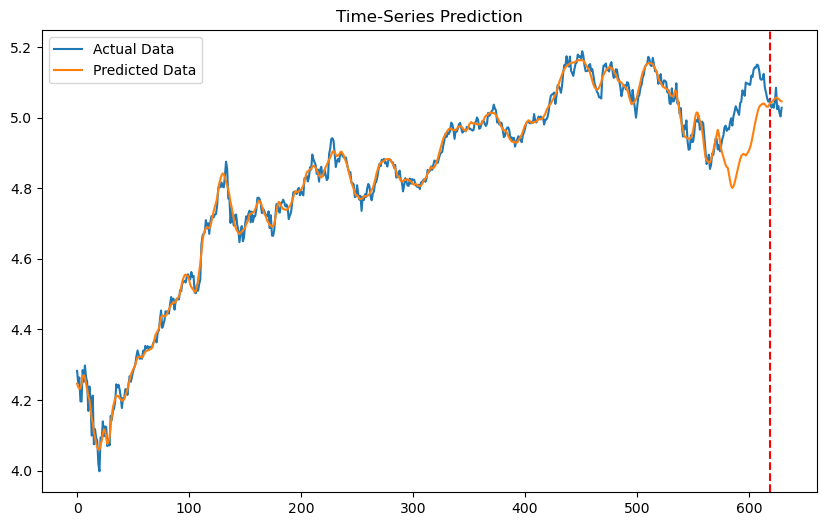

In [79]:
df_X_ss = ss.transform(X) # old transformers
df_y_mm = mm.transform(y.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, n_steps_in, n_steps_out)
# converting to tensors
df_X_ss = (torch.Tensor(df_X_ss))
df_y_mm = (torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], n_steps_in, df_X_ss.shape[2])).to(device)

train_predict = optimal_model(df_X_ss) # forward pass
data_predict = train_predict.cpu().data.numpy() # move to cpu then to numpy conversion
dataY_plot = df_y_mm.data.cpu().numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

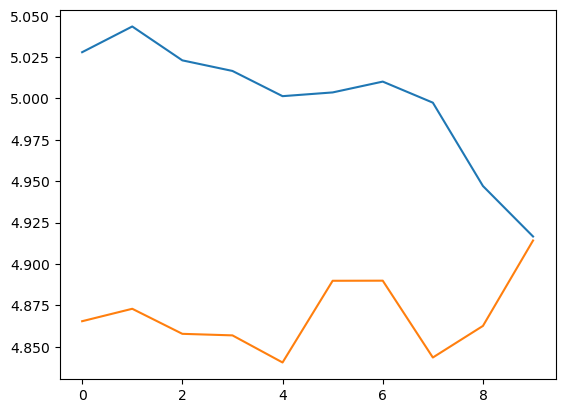

In [83]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.cpu().detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].cpu().detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

Load Model so don;t have to re-train
```python 
loaded_model = LSTM(
    num_classes=y_train_tensors.shape[1],
    input_size=X_train_tensors_final.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

loaded_model.load_state_dict(torch.load("optimal_lstm_model.pth"))
loaded_model.eval()
```

In [ ]:
loaded_model = LSTM(
    num_classes=y_train_tensors.shape[1],
    input_size=X_train_tensors_final.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

loaded_model.load_state_dict(torch.load("optimal_lstm_model.pth"))
loaded_model.eval()

### Metrics

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Convert tensors to numpy arrays
y_train_np = y_train_tensors.cpu().numpy()
y_test_np = y_test_tensors.cpu().numpy()
train_preds_np = train_preds.cpu().numpy()
test_preds_np = test_preds.cpu().numpy()

# Calculate MSE for training and test sets
train_mse = mean_squared_error(y_train_np, train_preds_np)
test_mse = mean_squared_error(y_test_np, test_preds_np)

print(f"Training MSE: {train_mse:.8f} ; Test MSE: {test_mse:.8f}")

Training MSE: 0.00027268 ; Test MSE: 0.00217610


In [89]:
mean_absolute_percentage_error(y_train_tensors.cpu().numpy(), train_preds.cpu().numpy())

430082720000.0